In [1]:
import sys
from pathlib import Path
import os
import warnings

sys.path.append(os.getenv("SPIKECOUNTER_PATH"))
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler

import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from skimage import exposure, measure, filters, transform, morphology
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils

warnings.filterwarnings("once")
plt.style.use(
    os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
)
ss = StandardScaler()

In [2]:
expt_dir_name = "20230308_TCF_nlsmCh_nkx2.5_LOI"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure5/", expt_dir_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"
um_per_px = 0.265*4

Combine TCF and nkx snaps

In [3]:
os.makedirs(rootdir/"analysis/combined_snaps", exist_ok=True)
os.makedirs(rootdir/"analysis/combined_snaps/RGB", exist_ok=True)
snap_metadata = pd.read_csv(rootdir/"Snaps/analysis/experiment_data.csv")

In [4]:
snap_metadata = utils.process_experiment_metadata(snap_metadata, regexp_dict={
                                                "array": r"(?<=\d\d)\w\w(?=_)", 
                                                "embryo": r"(?<=_)\w\d+(?=_)",
                                                "marker":r"(?<=_)[A-Za-z0-9]+(?=.tif)"})
snap_metadata["marker"] = snap_metadata["marker"].str.lower()
snap_metadata = snap_metadata[snap_metadata["embryo"] != "None"]
snap_metadata = snap_metadata[snap_metadata["marker"] != "outer"]
snap_metadata["embryo"] = snap_metadata["array"] + "_" + snap_metadata["embryo"]
snap_metadata = snap_metadata.set_index("marker")

In [5]:
expt_info = utils.process_experiment_metadata(pd.read_csv(Path(rootdir,"analysis", subfolder, "experiment_data.csv")),
                                             regexp_dict={"array": r"(?<=\d\d)\w\w(?=_)",  "embryo": r"(?<=_)\w\d+$"})
expt_info = expt_info[expt_info["embryo"] != "None"]
expt_info["embryo"] = expt_info["array"] + "_" + expt_info["embryo"]
expt_info["offset"] -= expt_info["offset"].iloc[0]
expt_info = expt_info.reset_index(drop=True)

In [6]:
matched_nkx_snaps = utils.match_experiments_to_snaps(expt_info, snap_metadata.loc["nkx"])
matched_tcf_snaps = utils.match_experiments_to_snaps(expt_info, snap_metadata.loc["tcf"])

In [7]:
expt_info["nkx_snap"] = matched_nkx_snaps["snap_file"]
expt_info["tcf_snap"] = matched_tcf_snaps["snap_file"]

In [8]:
def crop_min_shape(im1, im2):
    min_shape = np.min([im1.shape[:2], im2.shape[:2]], axis=0)
    
    diff_shape_im1 = np.array(im1.shape[:2]) - min_shape
    diff_shape_im2 = np.array(im2.shape[:2]) - min_shape
    
    cropped_im1 = im1[diff_shape_im1[0]//2:diff_shape_im1[0]//2+min_shape[0],
                           diff_shape_im1[1]//2:diff_shape_im1[1]//2+min_shape[1]]
    cropped_im2 = im2[diff_shape_im2[0]//2:diff_shape_im2[0]//2+min_shape[0],
                            diff_shape_im2[1]//2:diff_shape_im2[1]//2+min_shape[1]]
    
    return cropped_im1, cropped_im2

In [9]:
os.makedirs(output_datadir/"combined_snaps",  exist_ok=True)
for i in range(len(matched_nkx_snaps)):
    try:
        nkx_snap = skio.imread(Path(rootdir, "Snaps", matched_nkx_snaps["snap_file"].iloc[i]))
        tcf_snap = skio.imread(Path(rootdir, "Snaps", matched_tcf_snaps["snap_file"].iloc[i]))
    except IndexError:
        continue
    
    cropped_nkx, cropped_tcf = crop_min_shape(nkx_snap, tcf_snap)
    combined_snap = np.stack([cropped_nkx, cropped_tcf], axis=0)
    combined_snap_rgb = np.stack([
        exposure.rescale_intensity(cropped_tcf,in_range=tuple(np.nanpercentile(cropped_tcf,
                [2,99])), out_range = np.uint8),
        exposure.rescale_intensity(cropped_nkx,in_range=tuple(np.nanpercentile(cropped_nkx,
                [2,99])), out_range = np.uint8),
        np.zeros_like(cropped_nkx, dtype=np.uint8)], axis=0)
    skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif"), combined_snap)
    skio.imsave(output_datadir/"combined_snaps"/f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif", combined_snap)
    skio.imsave(Path(rootdir, "analysis", "combined_snaps", "RGB", f"{matched_nkx_snaps['file_name'].iloc[i]}_combined_rgb.tif"), combined_snap_rgb)

/tmp/ipykernel_94633/2649405735.py:17: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/095713UL_F2_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif"), combined_snap)
/tmp/ipykernel_94633/2649405735.py:18: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/095713UL_F2_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif", combined_snap)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/tifffile/tifffile.py:891: DeprecationWarning: TiffWriter: data with shape (3, 864, 864) and dtype 'uint8'' are stored as RGB with separate component planes. Future versions will store such data as MINISBLACK in separate pages by default unless the

/tmp/ipykernel_94633/2649405735.py:18: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/111945UR_A1_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif", combined_snap)
/tmp/ipykernel_94633/2649405735.py:17: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/112335UR_A2_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif"), combined_snap)
/tmp/ipykernel_94633/2649405735.py:18: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/112335UR_A2_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{matche

/tmp/ipykernel_94633/2649405735.py:17: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/120807UL_F1_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif"), combined_snap)
/tmp/ipykernel_94633/2649405735.py:18: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/120807UL_F1_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif", combined_snap)
/tmp/ipykernel_94633/2649405735.py:17: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/121221UL_E3_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{matched_nkx_snaps['file_name'].iloc[i]}_combined.tif"), com

/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:782: FutureWarning: `selem` is a deprecated argument name for `binary_opening`. It will be removed in version 1.0. Please use `footprint` instead.
  mask = morphology.binary_opening(mask, selem=morphology.disk(opening_size))
/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:784: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.
  mask = morphology.binary_closing(mask, selem=morphology.disk(closing_size))
/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:919: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p, res, _, _ = np.linalg.lstsq(A, b)
/n/home11/bjia/SpikeCounter/spikecounter/ana

('09:57:13', '095713UL_F2', 0, 'UL', 'UL_F2', '095846UL_F2_nkx.tiff', '100033UL_F2_TCF.tiff', 1157.9882649364827, 900.4943321971259, 122, 138, 121, 139)
('10:13:55', '101355UL_F2', 1002, 'UL', 'UL_F2', '101515UL_F2_nkx.tiff', '101541UL_F2_TCF.tiff', 1144.9290359037711, 849.6500412410999, 98, 133, 78, 120)
('10:27:35', '102735UL_F2', 1822, 'UL', 'UL_F2', '102826UL_F2_nkx.tiff', '102846UL_F2_tcf.tiff', 1358.295889127438, 1025.434312287397, 105, 137, 105, 138)
('10:31:59', '103159UL_E3', 2086, 'UL', 'UL_E3', '103335UL_E3_nkx.tiff', '103405UL_E3_tcf.tiff', 942.9715028309292, 716.4871154802581, 143, 116, 144, 114)
('10:47:31', '104731UL_F1', 3018, 'UL', 'UL_F1', '104901UL_F1_nkx.tiff', '104934UL_F1_tcf.tiff', 825.852885476659, 499.21714154292613, 129, 150, 129, 149)
('10:51:18', '105118UL_E1', 3245, 'UL', 'UL_E1', '105224UL_E1_nkx.tiff', '105245UL_E1_tcf.tiff', 832.0829745575845, 473.14995574310564, 64, 125, 61, 102)
('10:57:26', '105726UR_A1', 3613, 'UR', 'UR_A1', '110219UR_A1_nkx.tiff', '

/n/home11/bjia/SpikeCounter/spikecounter/ui/visualize.py:361: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axes = plt.subplots(2, 3, figsize=(14, 8))


('11:57:42', '115742UR_A1', 7229, 'UR', 'UR_A1', '115834UR_A1_nkx.tiff', '115915UR_A1_tcf.tiff', 696.1604618940903, 588.1640837874263, 84, 173, 82, 162)
('12:00:42', '120042UR_A2', 7409, 'UR', 'UR_A2', '120136UR_A2_nkx.tiff', '120205UR_A2_tcf.tiff', 647.0912216165406, 397.63601544859665, 67, 133, 66, 133)
('12:08:07', '120807UL_F1', 7854, 'UL', 'UL_F1', '120858UL_F1_nkx.tiff', '121022UL_F1_tcf.tiff', 567.8115161608282, 448.1345677330082, 95, 152, 97, 152)
('12:12:21', '121221UL_E3', 8108, 'UL', 'UL_E3', '121314UL_E3_nkx.tiff', '121340UL_E3_tcf.tiff', 282.6710172596365, 191.47160574915839, 183, 111, 183, 111)
('12:34:16', '123416UR_A1', 9423, 'UR', 'UR_A1', '123623UR_A1_nkx.tiff', '123640UR_A1_tcf.tiff', 635.4583393112484, 431.40945507743123, 139, 147, 139, 147)
('12:38:12', '123812UR_A2', 9659, 'UR', 'UR_A2', '123912UR_A2_nkx.tiff', '123930UR_A2_tcf.tiff', 560.115423198358, 390.197392285049, 67, 22, 47, 48)


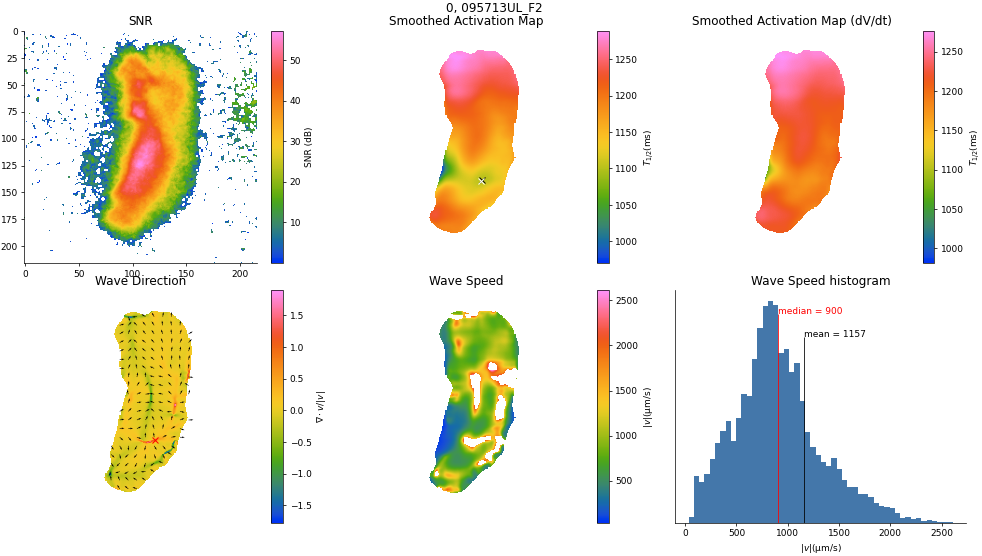

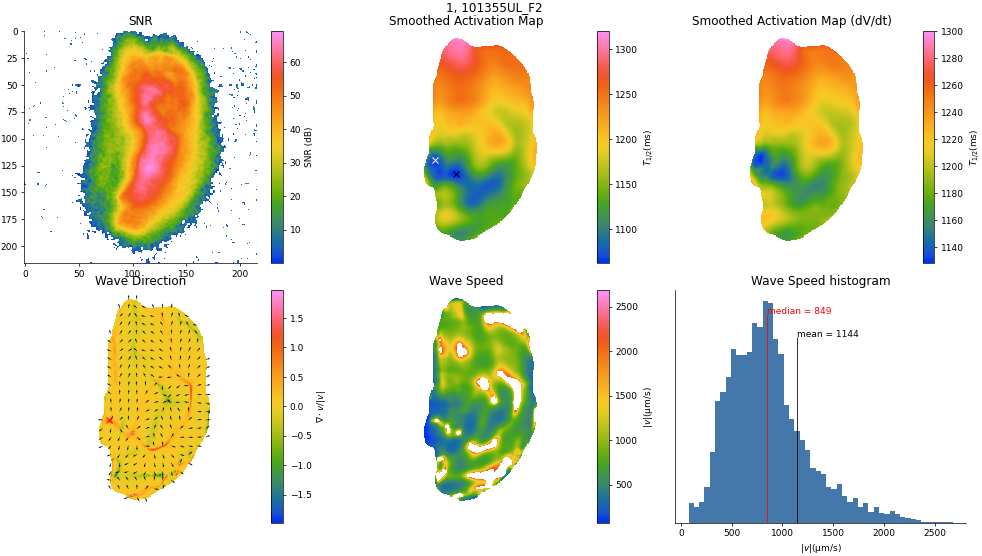

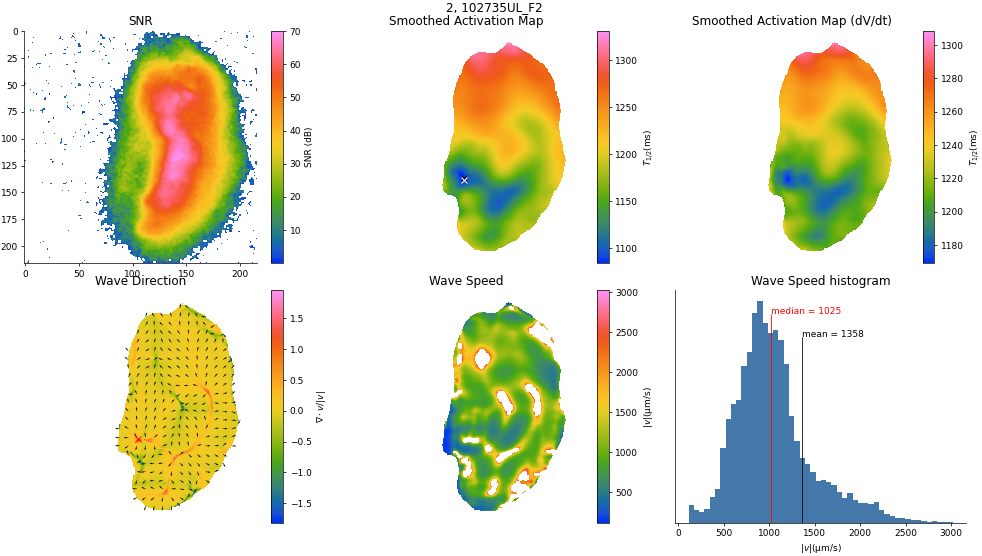

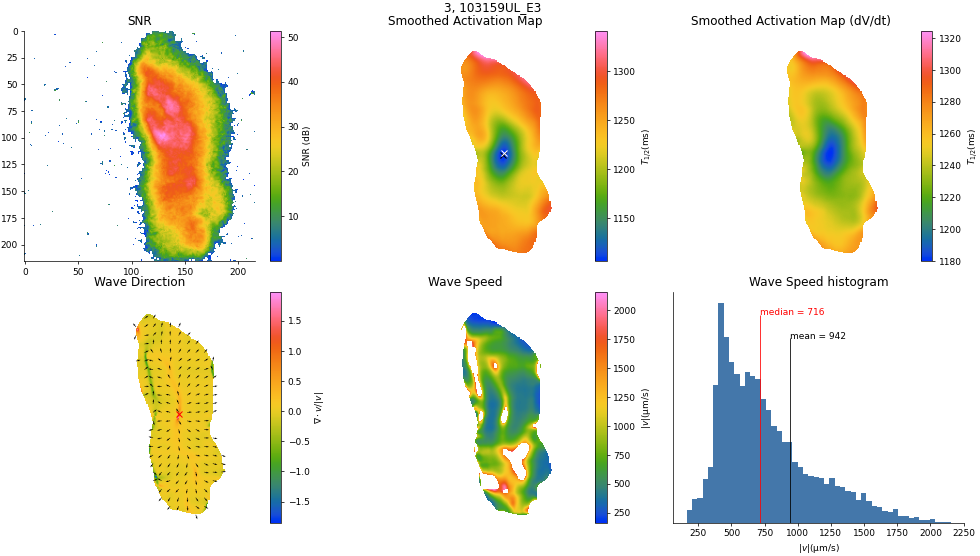

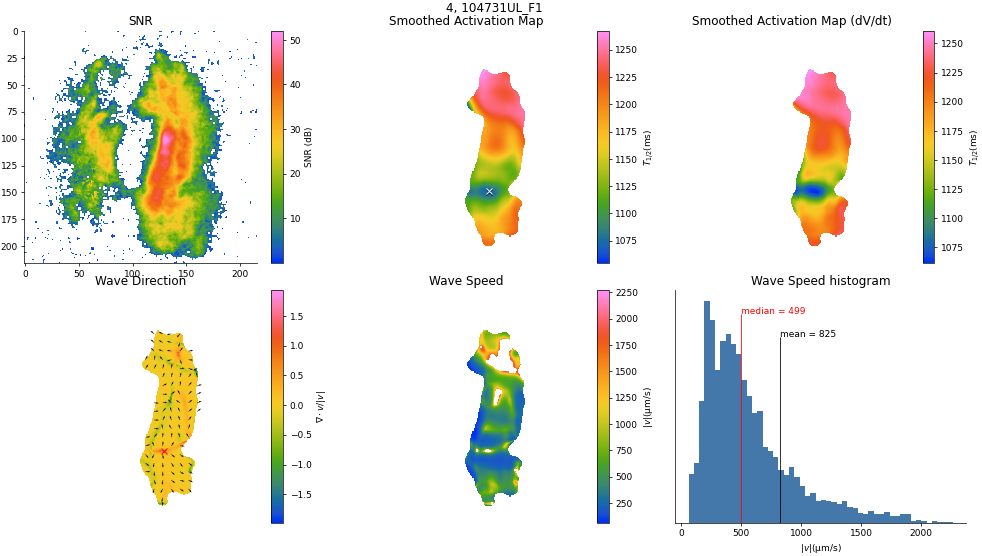

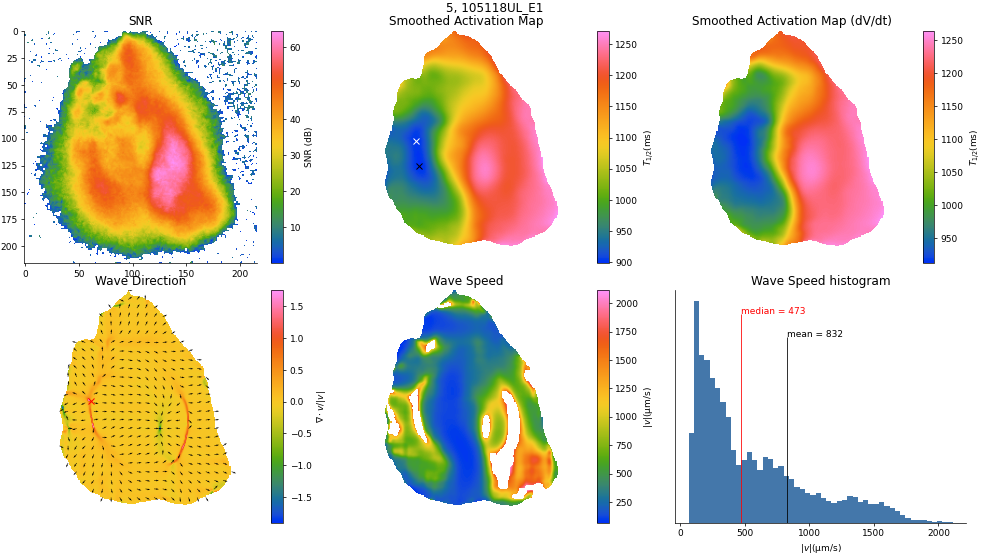

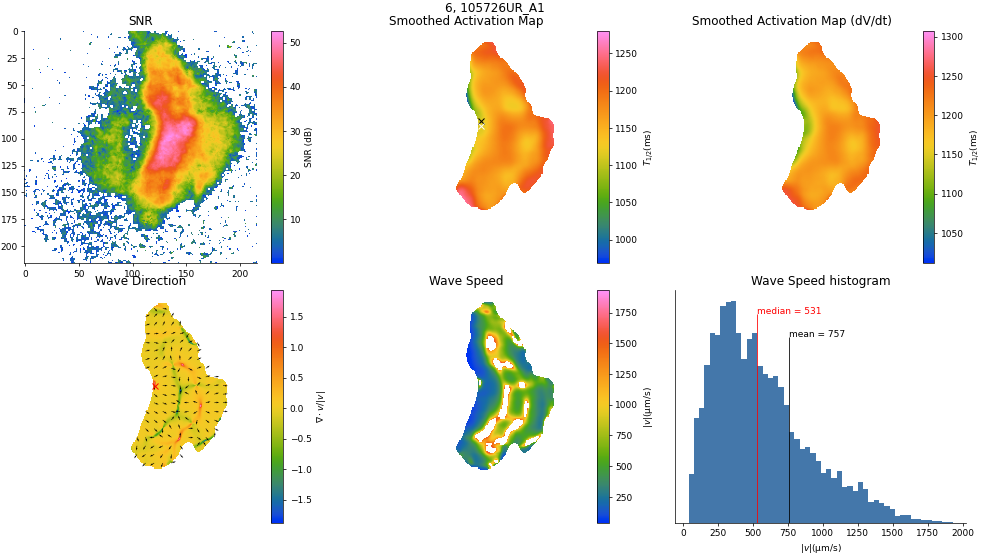

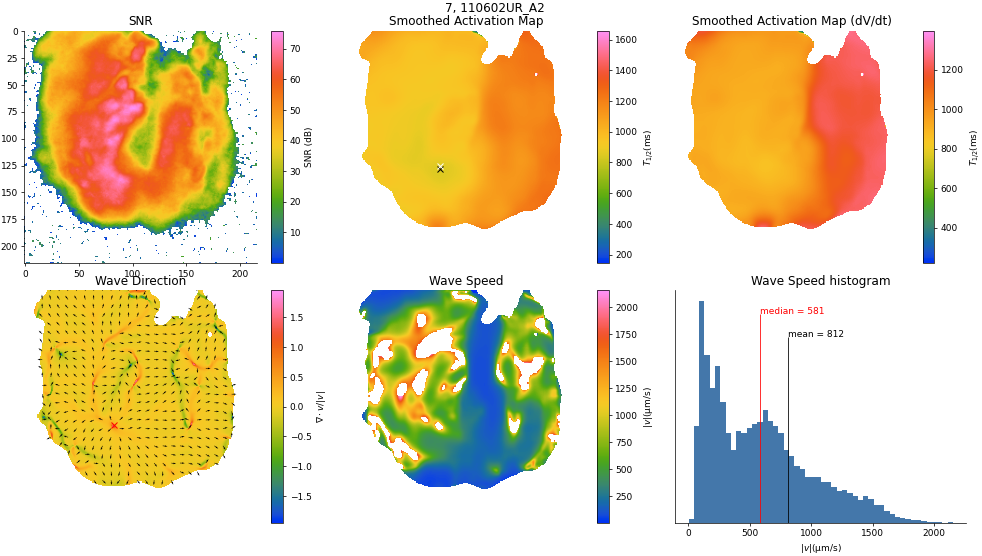

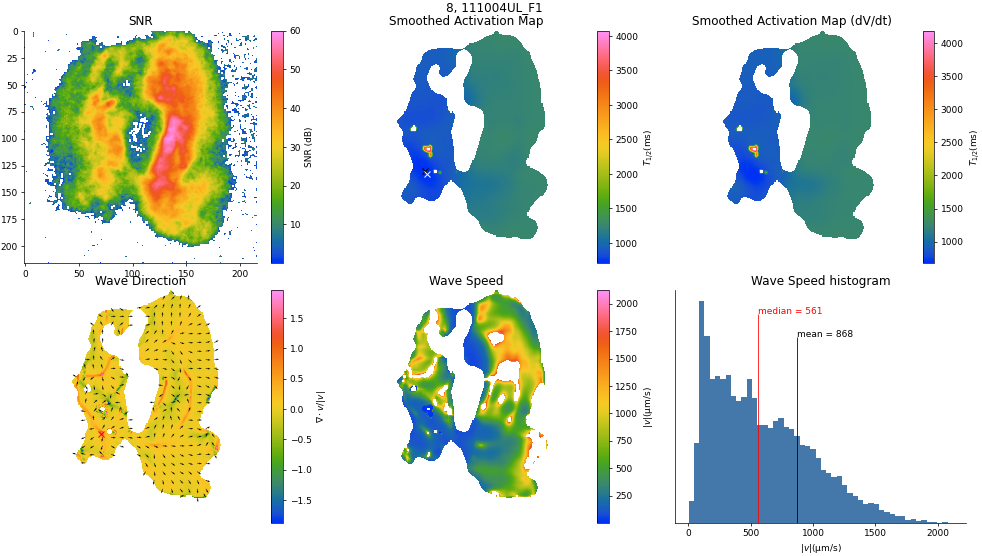

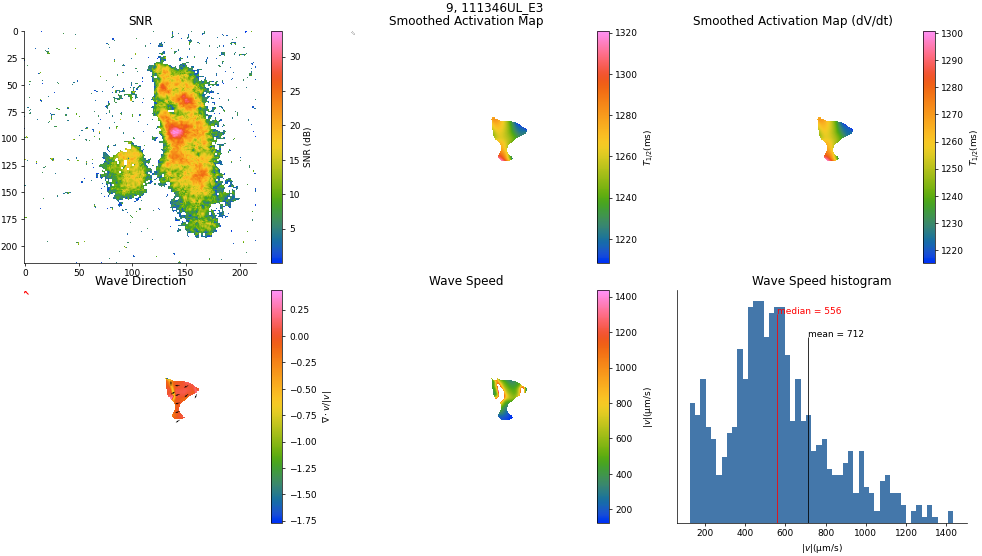

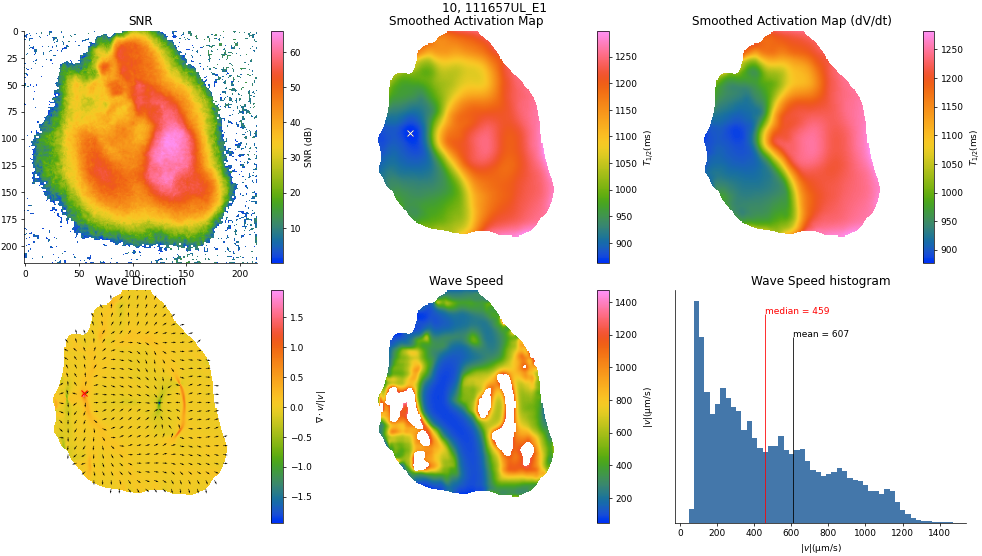

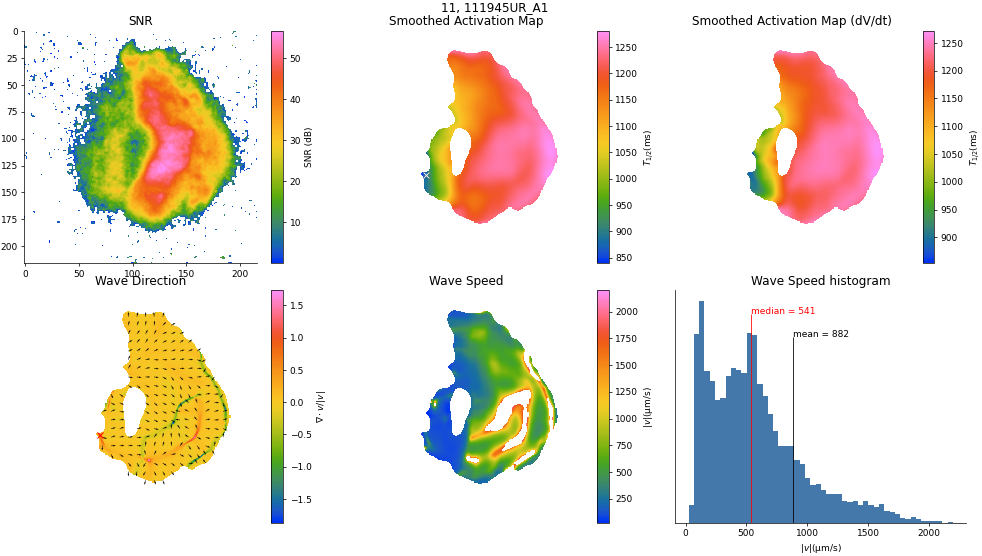

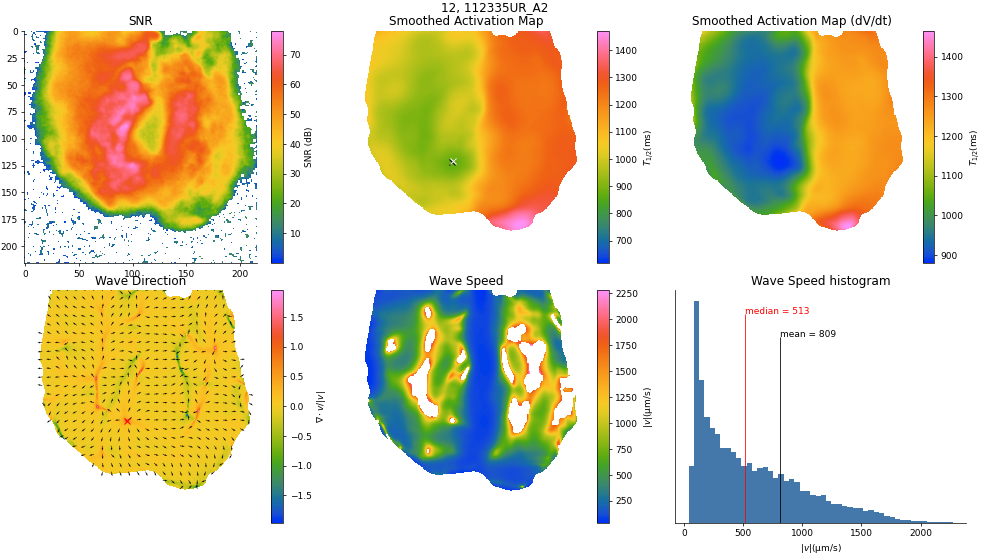

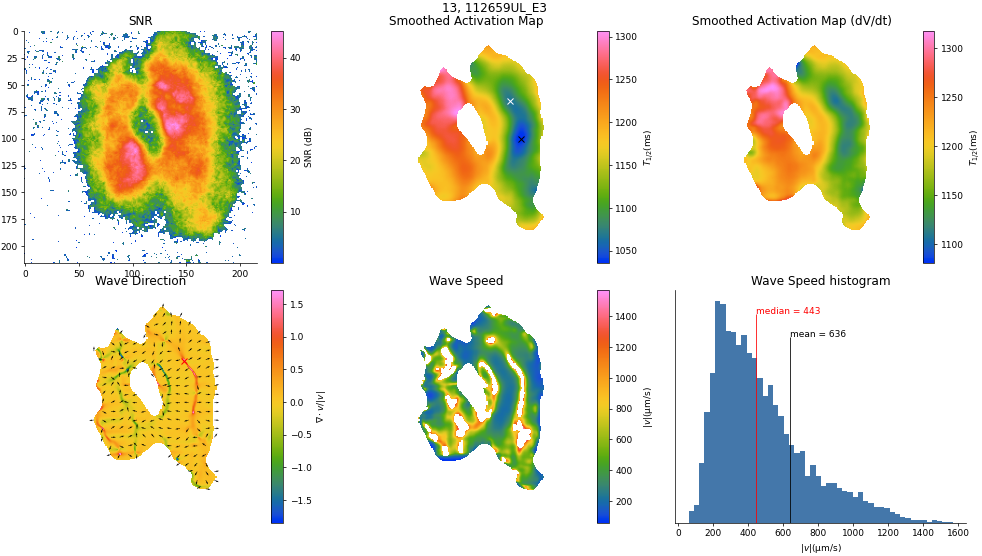

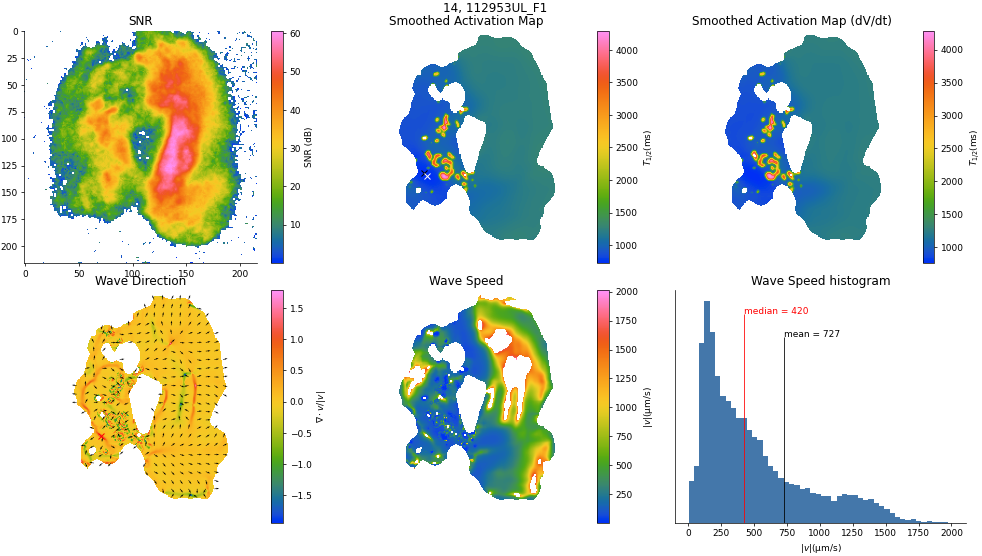

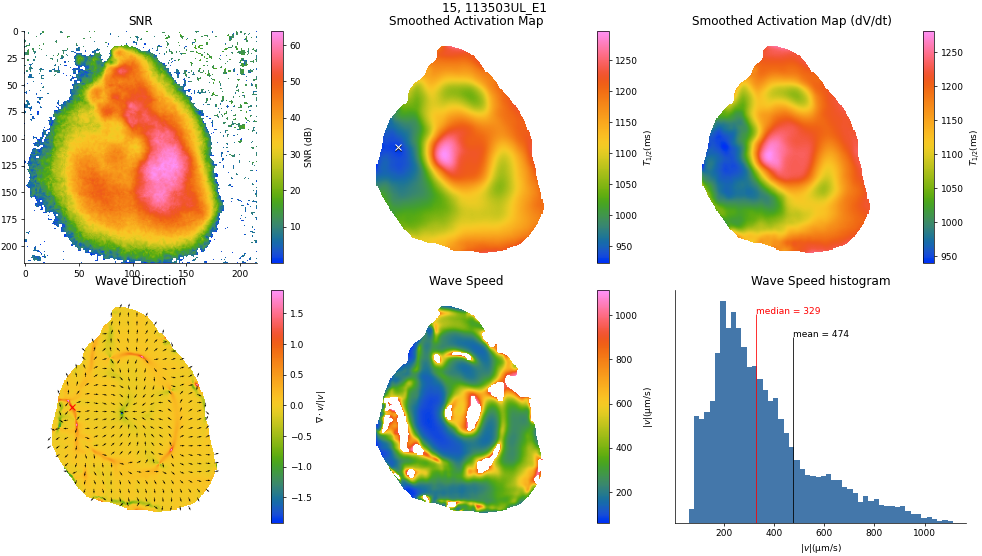

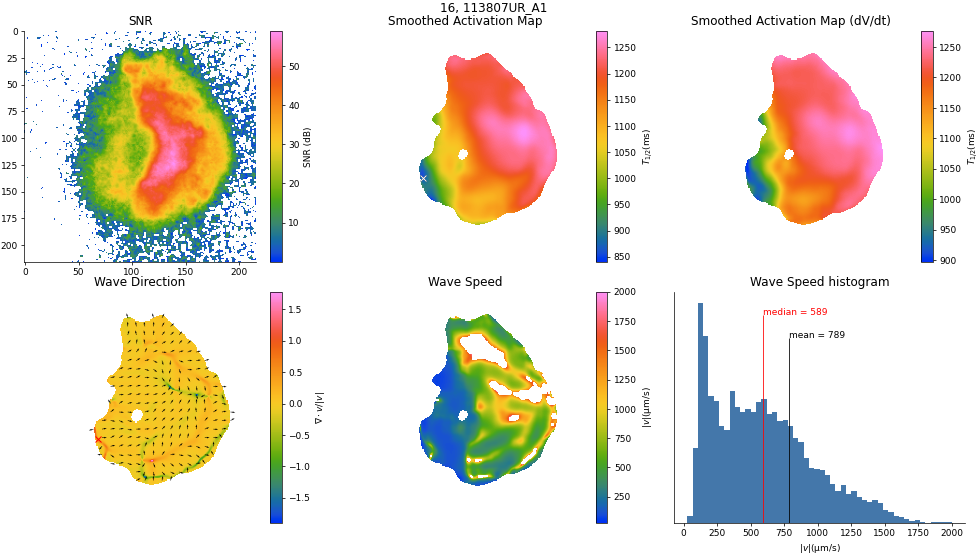

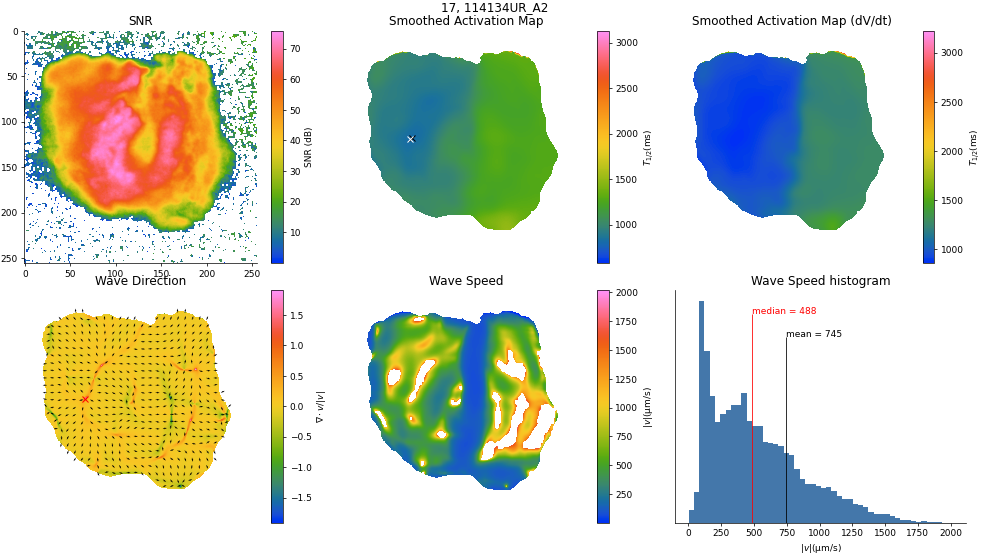

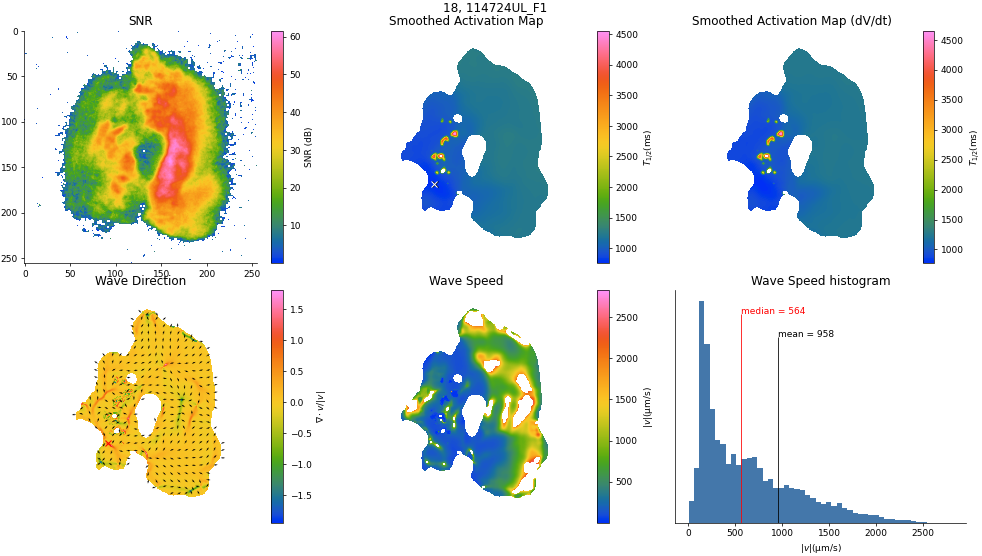

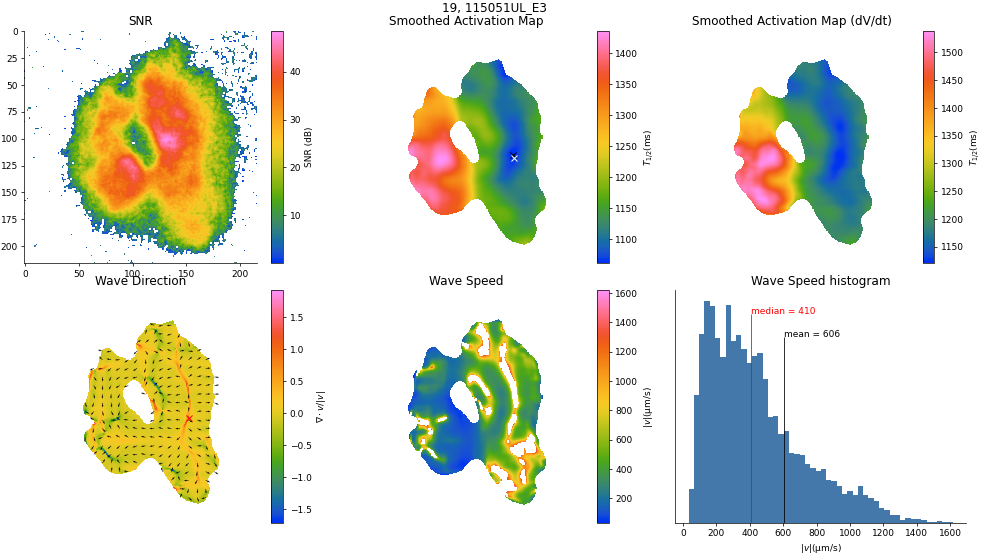

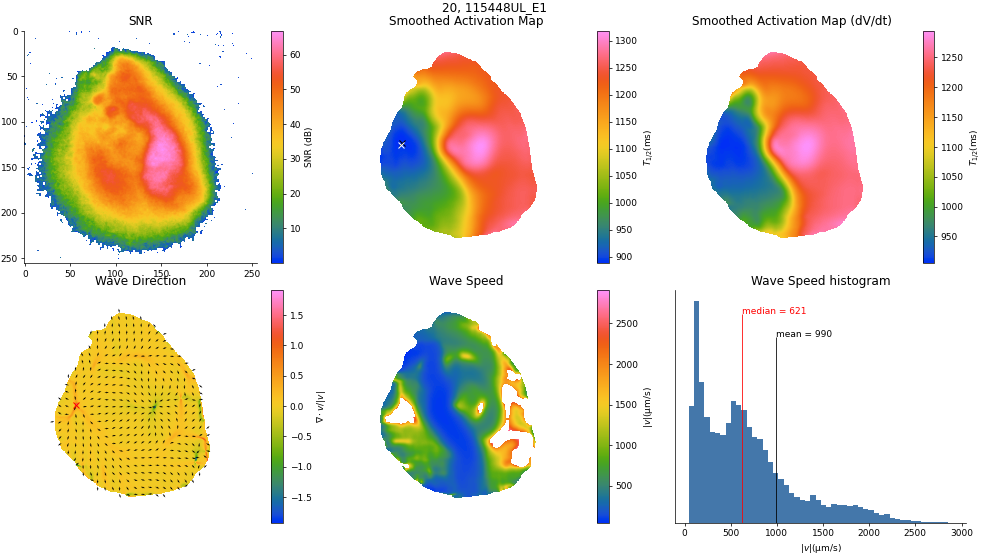

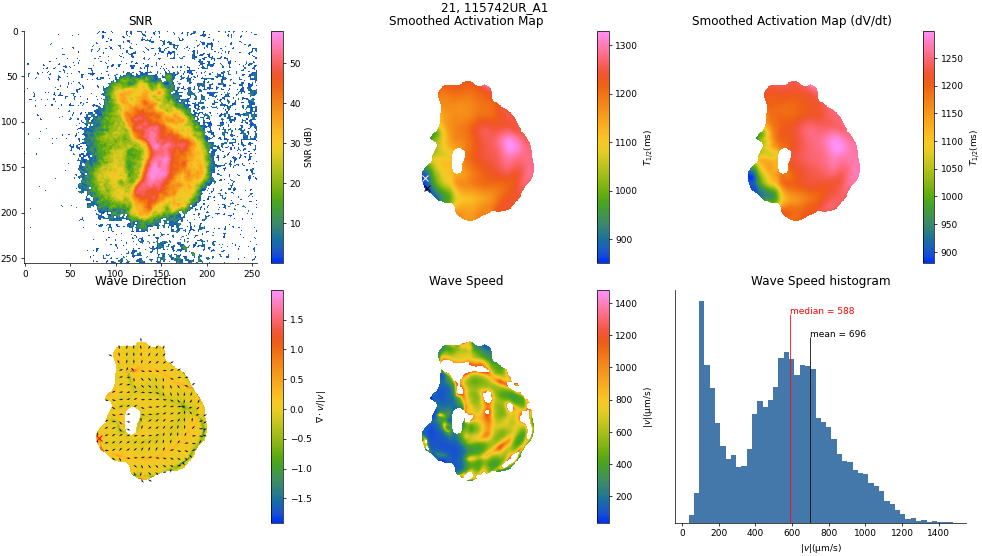

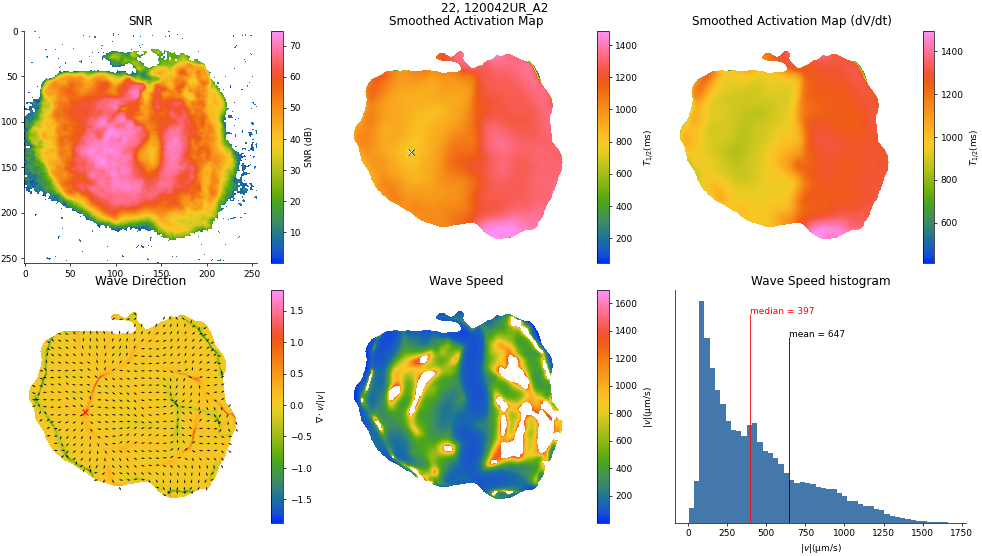

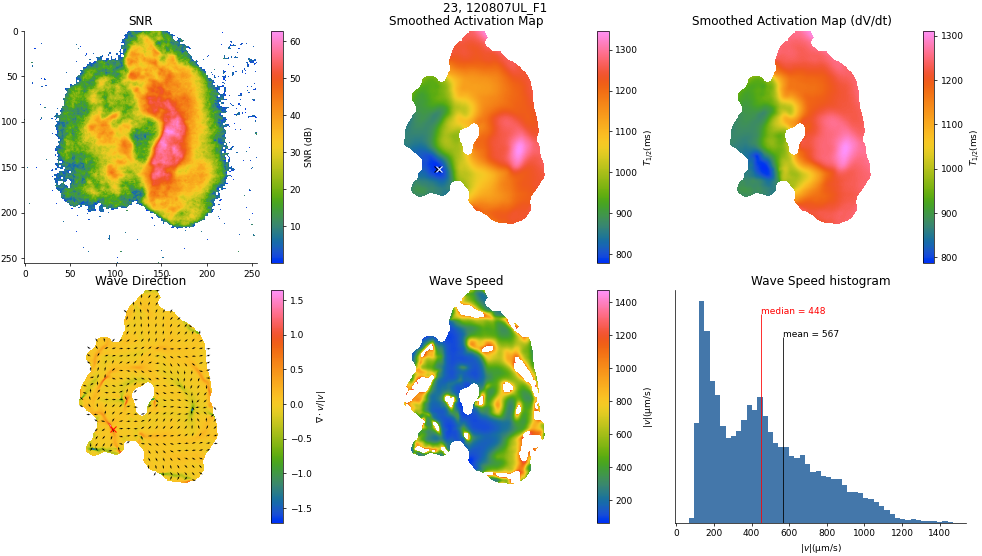

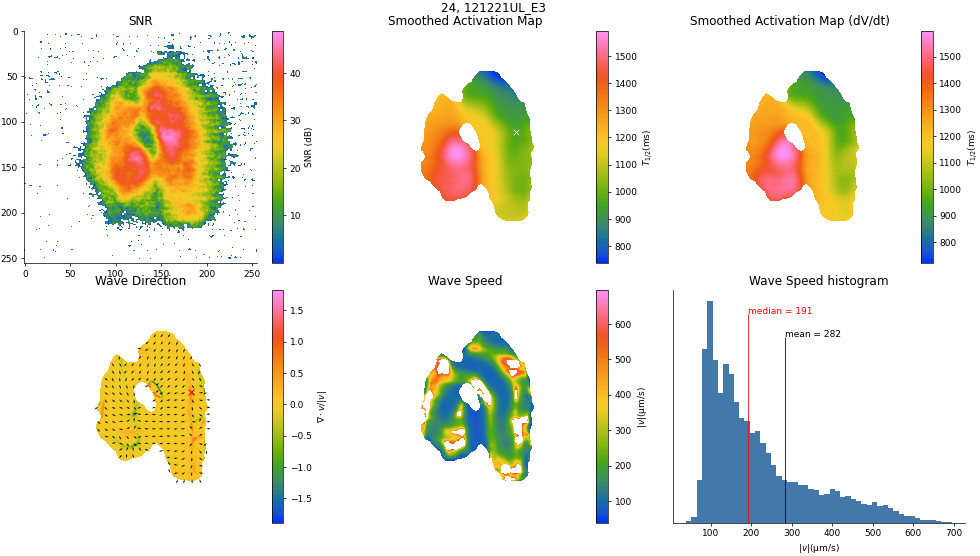

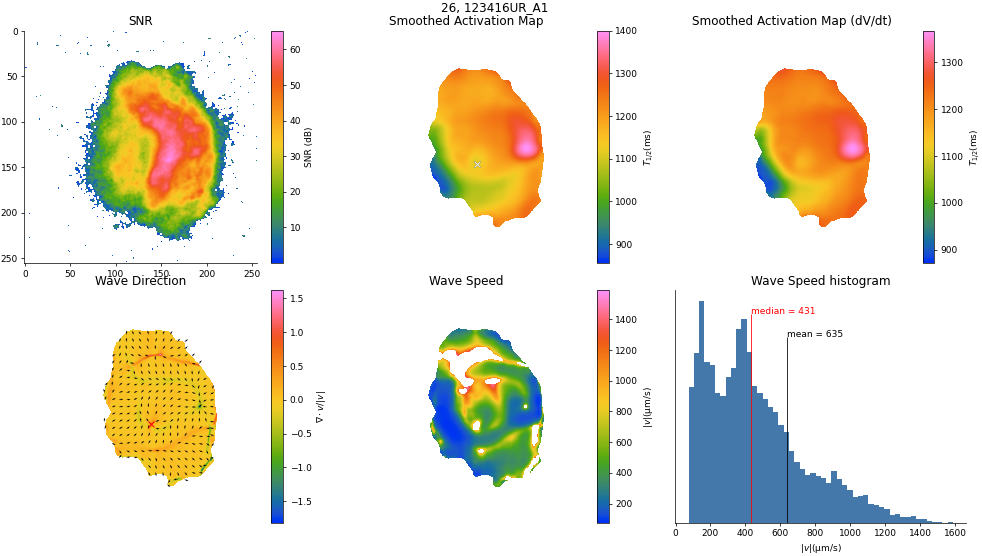

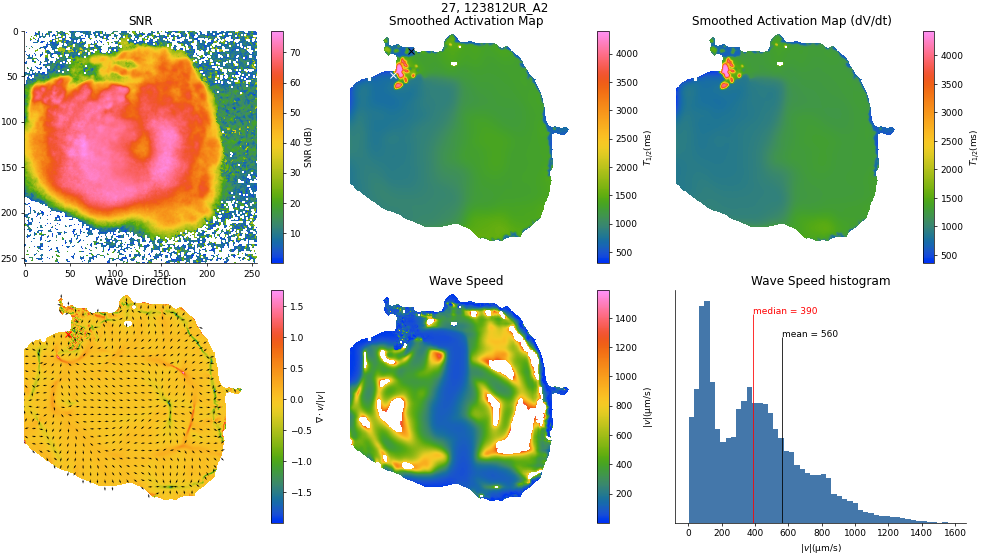

In [34]:
plt.close("all")
data = []
mint = []
maxdiv = []
erred_files = {}
smoothed_ts = {}
smoothed_ts_dv = {}
amplitudes = {}
divergences = {}
velocities = {}
for i in range(expt_info.shape[0]):
    filename = expt_info["file_name"].iloc[i]
    os.makedirs(output_datadir/"analysis"/subfolder/filename, exist_ok=True)
    snapt = f"{filename}_snapt.npz"
    if snapt in os.listdir(rootdir/"analysis"/subfolder):
        matdata = mat73.loadmat(rootdir/filename/"output_data_py.mat")["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))
        
        beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

        try:
            amplitude = (np.abs(beta[2] - 1)/beta[5])**2 #SNR
            db = 20*np.log10(amplitude)
            db[db < 0] = np.nan
#             threshold = min(np.percentile(amplitude, 55), 1.01)
            q = images.analyze_wave_dynamics(beta, dt, um_per_px, deltax=13, threshold=10, opening_size=2)
            if q is None:
                continue
            else:
                rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expt_info.iloc[i]) + rd
            data.append(rowdata)
            print(rowdata)
        except Exception as e:
            print(e)
            erred_files[filename] = e
            continue
        
        smoothed_ts[filename] = Tsmoothed_dv
        amplitudes[filename] = beta[2]
        divergences[filename] = divergence
        velocities[filename] = v
        visualize.plot_wave_analysis(db, rd, Tsmoothed, Tsmoothed_dv,\
                           divergence, v, f'''{i}, {expt_info.iloc[i]["file_name"]}''')
        plt.savefig(os.path.join(rootdir/"analysis"/subfolder/filename/"waveplots.tif"))
        plt.savefig(os.path.join(output_datadir/"analysis"/subfolder/filename/"waveplots.tif"))
        
data = pd.DataFrame(data, columns = expt_info.columns.tolist() + ['mean_speed', 'median_speed', 'loi_x',\
                                                                  'loi_y', 'loi_x_dv', 'loi_y_dv'])

In [35]:
data.to_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")
with (output_datadir/"analysis"/subfolder/"wavemap_data.pickle").open(mode="wb") as f:
    pickle.dump({"erred_files": erred_files,
            "smoothed_ts": smoothed_ts,
            "smoothed_ts_dv": smoothed_ts_dv,
            "amplitudes": amplitudes,
            "divergences": divergences,
            "velocities": velocities}, f)

Redoing snap matching after wavemaps are processed

In [11]:
data = pd.read_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")
with (output_datadir/"analysis"/subfolder/"wavemap_data.pickle").open(mode="rb") as f:
    ob = pickle.load(f)
    erred_files = ob["erred_files"]
    smoothed_ts = ob["smoothed_ts"]
    smoothed_ts_dv = ob["smoothed_ts_dv"]
    amplitudes = ob["amplitudes"]
    divergences = ob["divergences"]
    velocities = ob["velocities"]

In [33]:
os.makedirs(output_datadir/"combined_snaps/RGB",  exist_ok=True)
color2 = np.array([0,255,255])[None,None,:]
# color1 = np.array([255,0,0])[None,None,:]

color1 = np.array([255,0,0])[None,None,:]
for i, row in data.iterrows():
    file_name = row["file_name"]
    try:
        nkx_snap = skio.imread(Path(rootdir, "Snaps", row["nkx_snap"]))
        tcf_snap = skio.imread(Path(rootdir, "Snaps", row["tcf_snap"]))
    except IndexError:
        continue
    combined_snap = np.stack([cropped_nkx, cropped_tcf], axis=0)
    cropped_nkx, cropped_tcf = crop_min_shape(nkx_snap, tcf_snap)
    cropped_tcf_rescaled = color1*exposure.rescale_intensity(cropped_tcf,in_range=tuple(np.nanpercentile(cropped_tcf,
            [2,99])), out_range = (0,1))[:,:,None]
    cropped_nkx_rescaled = color2*exposure.rescale_intensity(cropped_nkx,in_range=tuple(np.nanpercentile(cropped_nkx,
            [2,99])), out_range = (0,1))[:,:,None]
    combined_snap_rgb = np.minimum(cropped_tcf_rescaled + cropped_nkx_rescaled, 255).astype(np.uint8)
#     plt.imshow(combined_snap_rgb)
    skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{file_name}_combined.tif"), combined_snap)
    skio.imsave(output_datadir/"combined_snaps"/f"{file_name}_combined.tif", combined_snap)
    skio.imsave(Path(rootdir, "analysis", "combined_snaps", "RGB", f"{file_name}_combined_rgb.tif"), combined_snap_rgb)
    skio.imsave(output_datadir/"combined_snaps"/"RGB"/f"{file_name}_combined_rgb.tif", combined_snap_rgb)

/tmp/ipykernel_95370/3114428283.py:21: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/095713UL_F2_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{file_name}_combined.tif"), combined_snap)
/tmp/ipykernel_95370/3114428283.py:22: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/095713UL_F2_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{file_name}_combined.tif", combined_snap)
/tmp/ipykernel_95370/3114428283.py:21: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/101355UL_F2_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{file_name}_combined.tif"), combined_snap)
/tmp/ipykernel_95370/3114428283.py:22: UserWarning: /net/fs-cohen01/srv/exp

/tmp/ipykernel_95370/3114428283.py:21: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/112659UL_E3_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{file_name}_combined.tif"), combined_snap)
/tmp/ipykernel_95370/3114428283.py:22: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/112659UL_E3_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{file_name}_combined.tif", combined_snap)
/tmp/ipykernel_95370/3114428283.py:21: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/112953UL_F1_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{file_name}_combined.tif"), combined_snap)
/tmp/ipykernel_95370/3114428283.py:22: UserWarning: /net/fs-cohen01/srv/exp

/tmp/ipykernel_95370/3114428283.py:21: UserWarning: /n/holyscratch01/cohen_lab/bjia/20230308_TCF_nlsmCh_nkx2.5_LOI/analysis/combined_snaps/123812UR_A2_combined.tif is a low contrast image
  skio.imsave(Path(rootdir, "analysis", "combined_snaps", f"{file_name}_combined.tif"), combined_snap)
/tmp/ipykernel_95370/3114428283.py:22: UserWarning: /net/fs-cohen01/srv/export/cohen_lab/share/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure4/20230308_TCF_nlsmCh_nkx2.5_LOI/combined_snaps/123812UR_A2_combined.tif is a low contrast image
  skio.imsave(output_datadir/"combined_snaps"/f"{file_name}_combined.tif", combined_snap)


(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)
(216, 216) (216, 216)
(216, 216) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)


/tmp/ipykernel_805043/2715228341.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(figsize=(1.8,1.8))


(256, 256) (256, 256)
(256, 256) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)
(256, 256) (256, 256)
(256, 256) (216, 216)


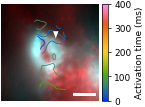

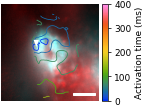

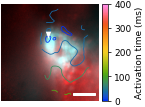

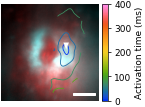

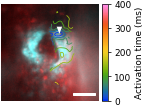

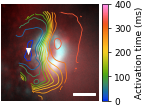

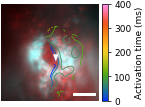

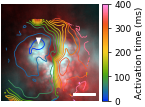

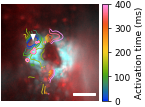

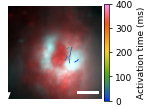

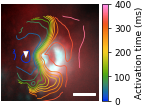

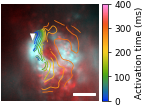

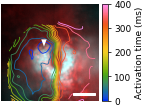

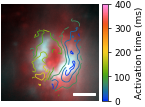

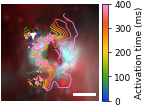

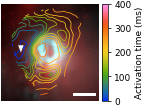

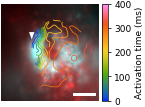

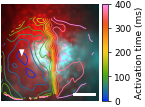

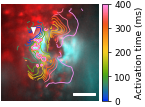

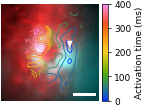

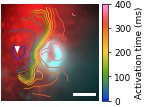

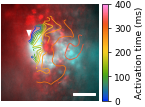

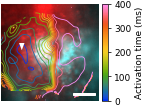

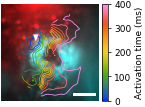

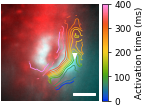

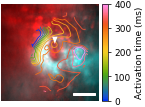

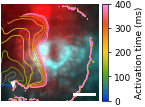

In [20]:
plt.close("all")
os.makedirs(rootdir/"analysis"/subfolder/"LOI_tcf_nkx", exist_ok=True)
os.makedirs(output_datadir/"LOI_tcf_nkx", exist_ok=True)
with (output_datadir/"analysis"/subfolder/"wavemap_data.pickle").open(mode="rb") as f:
    smoothed_ts = pickle.load(f)["smoothed_ts"]
master_img = np.zeros((216, 216,3))
p0 = 2
vmax = 400
for idx, row in data.iterrows():
    file_name = row["file_name"]
    tcf_nkx_img = skio.imread(Path(rootdir, "analysis", "combined_snaps", "RGB", f"{file_name}_combined_rgb.tif"))
    downscaled_tcf_nkx_img = transform.downscale_local_mean(tcf_nkx_img, (4,4,1)).astype(np.uint8)
    try:
        activation_map = smoothed_ts[file_name]
    except KeyError:
        continue
    cropped_tcf_nkx, cropped_activation_map = crop_min_shape(downscaled_tcf_nkx_img, activation_map)
#     print(activation_map.shape, cropped_activation_map.shape)
    cropped_tcf_nkx, _ = crop_min_shape(cropped_tcf_nkx, master_img)
    cropped_activation_map, _ = crop_min_shape(cropped_activation_map, master_img)
#     print(activation_map.shape, cropped_activation_map.shape)
#     print(cropped_tcf_nkx.shape)
    fv = cropped_activation_map[np.isfinite(cropped_activation_map)]
    Tsmoothed_apod = cropped_activation_map - np.percentile(fv, p0)        
    fig1, ax1 = plt.subplots(figsize=(1.8,1.8))
    ax1.imshow(cropped_tcf_nkx)
    cs = ax1.contour(Tsmoothed_apod, levels=np.linspace(0, vmax, 12), cmap="cet_CET_R1", zorder=0)
    visualize.draw_caret((row["loi_x_dv"]-(activation_map.shape[1]-216)//2,
                          row["loi_y_dv"]-(activation_map.shape[0]-216)//2), 12, 16, ax1, facecolor="white")
    ax1.set_ylim(0,cropped_tcf_nkx.shape[0])
#     ax1.set_title(file_name)
    ax1.axis("off")
    visualize.plot_img_scalebar(fig1, ax1, 160, 15, 50, 4, pix_per_um = 1/um_per_px, fontsize=9,
                              color="white", unit="\mu m", yax_direction="up", text_pos="below", scale=0.7,
                             show_label=False)
    norm = colors.Normalize(vmin=0, vmax=vmax)
    cax = fig1.add_axes([0.92, 0.13, 0.04, 0.75])
    cb = mpl.colorbar.ColorbarBase(cax, cmap="cet_CET_R1", norm=norm, label="Activation time (ms)")
    
    fig1.savefig(rootdir/"analysis"/subfolder/"LOI_tcf_nkx"/f"{file_name}.tif", dpi=300, bbox_inches="tight")
    fig1.savefig(output_datadir/"LOI_tcf_nkx"/f"{file_name}.tif", dpi=300, bbox_inches="tight")
    fig1.savefig(output_datadir/"LOI_tcf_nkx"/f"{file_name}.svg", dpi=300, bbox_inches="tight")

104731UL_F1 - example of two halves beating independently!

In [12]:
data = pd.read_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")
del data["Unnamed: 0"]
del data["array"]
data["freq"] = np.nan
data["isi_mean"] = np.nan
data["isi_std"] = np.nan
data["n_pks"] = np.nan
for i in range(data.shape[0]):
    filename = data[["file_name"]].values.ravel()[i]
    with open(os.path.join(rootdir, "analysis", subfolder, filename, "temporal_statistics.pickle"), "rb") as f:
        temp_stats = pickle.load(f)
        for k, v in temp_stats.items():
            data.at[i, k] = v
data["date"] = "20230308"

In [15]:
data.to_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")

### Calculate reference points for hearts

In [19]:
data["distance_to_cone"] = np.nan
print(data.shape)

(27, 18)


In [103]:
i = 26
snap_name = data["nkx_snap"].iloc[i]
filename = data["file_name"].iloc[i]
nkx = skio.imread(os.path.join(rootdir, "Snaps", snap_name))
mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "sta.tif")).mean(axis=0)
nkx = transform.downscale_local_mean(nkx, (4,4))
diff = (nkx.shape[0] - mean_img.shape[0])//2
if diff > 0:
    nkx = nkx[diff:-diff, diff:-diff]

(256, 256)
[0 1 2]


<IPython.core.display.Javascript object>


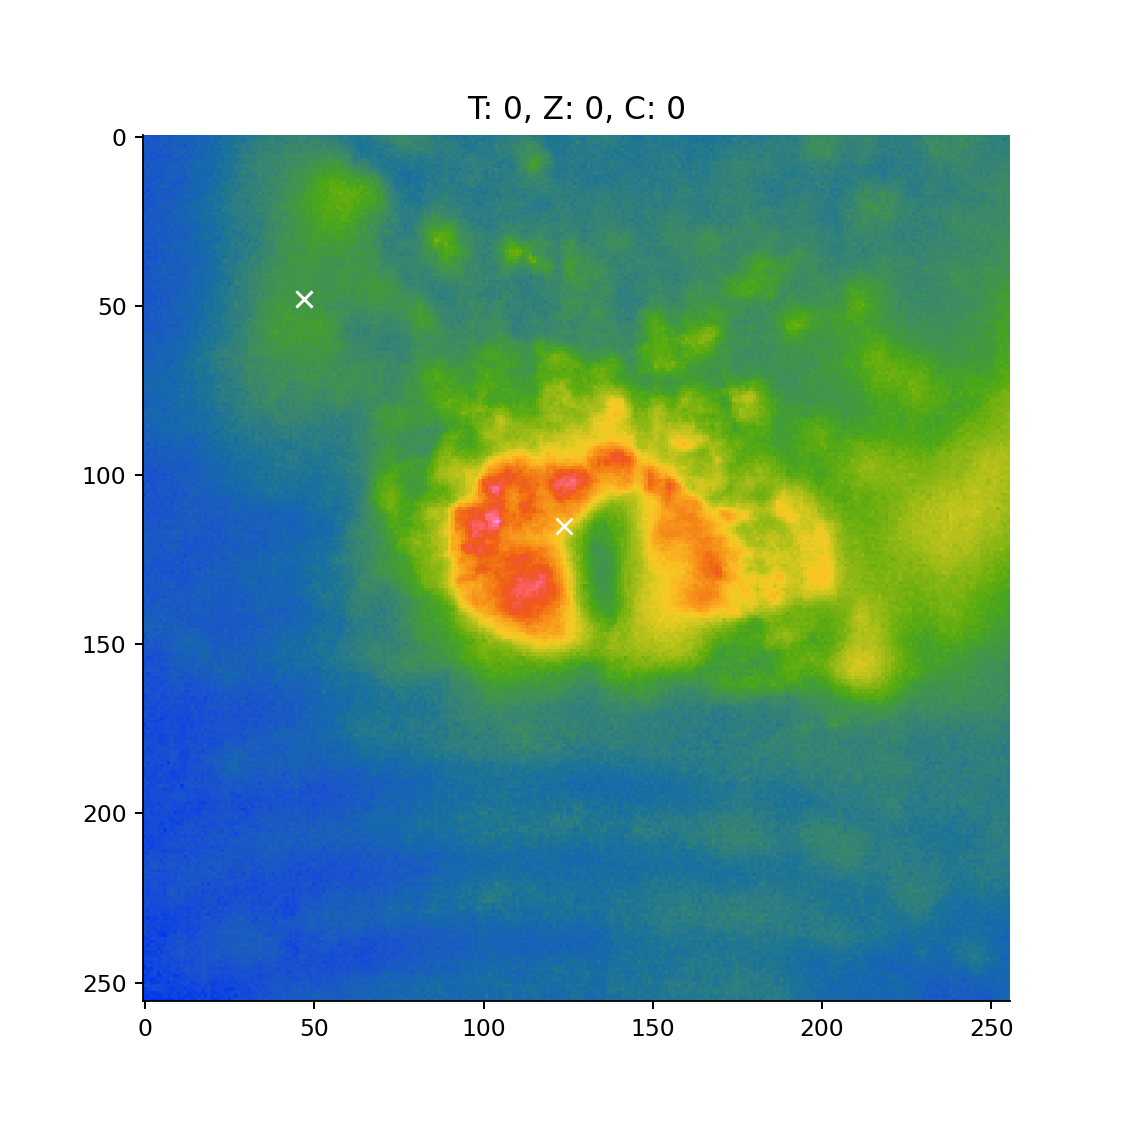

array([[47, 48]])

In [104]:
plt.close("all")
%matplotlib notebook
h = HyperStackViewer(nkx, width=6, height=6)
h.points = [[data["loi_x_dv"].iloc[i], data["loi_y_dv"].iloc[i]]]
h.select_points_clicky(1, append=True)

In [105]:
points = np.array(h.points)
dist = np.sum(np.diff(points, axis=0)**2)**0.5*um_per_px
dist = 0
data.at[i, "distance_to_cone"] = dist
data.to_csv(output_datadir/"analysis"/subfolder/"wavefront_data_full.csv", index=False)

In [111]:
data["expt_name"] = str(rootdir)
data["snap_file"] = data["nkx_snap"]
data.to_csv(output_datadir/"analysis"/subfolder/"wavefront_data_full.csv", index=False)

In [113]:
for i in range(27):
    snap_name = data["nkx_snap"].iloc[i]
    filename = data["file_name"].iloc[i]
    mean_img = skio.imread(os.path.join(rootdir, "analysis", subfolder, filename, "sta.tif")).mean(axis=0)
    data.at[i, "image_width"] = mean_img.shape[1]
    data.at[i, "image_height"] = mean_img.shape[0]

In [114]:
data.to_csv(output_datadir/"analysis"/subfolder/"wavefront_data_full.csv", index=False)

In [124]:
data["rel_offset_h"] = np.nan
data_by_embryo = data.set_index("embryo").sort_values("offset")
for idx in data_by_embryo.index.unique():
    data_by_embryo.loc[idx, "rel_offset_h"] = (data_by_embryo.loc[idx, "offset"] - data_by_embryo.loc[idx, "offset"].iloc[0])/3600

In [125]:
data = data_by_embryo.reset_index()

In [126]:
data.to_csv(output_datadir/"analysis"/subfolder/"wavefront_data_full.csv", index=False)

In [127]:
data

embryo start_time    file_name  offset              nkx_snap  \
0   UL_F2   09:57:13  095713UL_F2       0  095846UL_F2_nkx.tiff   
1   UL_F2   10:13:55  101355UL_F2    1002  101515UL_F2_nkx.tiff   
2   UL_F2   10:27:35  102735UL_F2    1822  102826UL_F2_nkx.tiff   
3   UL_E3   10:31:59  103159UL_E3    2086  103335UL_E3_nkx.tiff   
4   UL_F1   10:47:31  104731UL_F1    3018  104901UL_F1_nkx.tiff   
5   UL_E1   10:51:18  105118UL_E1    3245  105224UL_E1_nkx.tiff   
6   UR_A1   10:57:26  105726UR_A1    3613  110219UR_A1_nkx.tiff   
7   UR_A2   11:06:02  110602UR_A2    4129  110741UR_A2_nkx.tiff   
8   UL_F1   11:10:04  111004UL_F1    4371  111058UL_F1_nkx.tiff   
9   UL_E3   11:13:46  111346UL_E3    4593  111445UL_E3_nkx.tiff   
10  UL_E1   11:16:57  111657UL_E1    4784  111759UL_E1_nkx.tiff   
11  UR_A1   11:19:45  111945UR_A1    4952  112134UR_A1_nkx.tiff   
12  UR_A2   11:23:35  112335UR_A2    5182  112428UR_A2_nkx.tiff   
13  UL_E3   11:26:59  112659UL_E3    5386  112802UL_E3_nkx.tiff   
14  UL_F1   11:29:53  112953UL_F1    5560  113332UL_F1_nkx.tiff   
15  UL_E1   11:35:03  113503UL_E1    5870  113607UL_E1_nkx.tiff   
16  UR_A1   11:38:07  113807UR_A1    6054  113906UR_A1_nkx.tiff   
17  UR_A2   11:41:34  114134UR_A2    6261  114234UR_A2_nkx.tiff   
18  UL_F1   11:47:24  114724UL_F1    6611  114829UL_F1_nkx.tiff   
19  UL_E3   11:50:51  115051UL_E3    6818  115159UL_E3_nkx.tiff   
20  UL_E1   11:54:48  115448UL_E1    7055  115543UL_E1_nkx.tiff   
21  UR_A1   11:57:42  115742UR_A1    7229  115834UR_A1_nkx.tiff   
22  UR_A2   12:00:42  120042UR_A2    7409  120136UR_A2_nkx.tiff   
23  UL_F1   12:08:07  120807UL_F1    7854  120858UL_F1_nkx.tiff   
24  UL_E3   12:12:21  121221UL_E3    8108  121314UL_E3_nkx.tiff   
25  UR_A1   12:34:16  123416UR_A1    9423  123623UR_A1_nkx.tiff   
26  UR_A2   12:38:12  123812UR_A2    9659  123912UR_A2_nkx.tiff   

                tcf_snap   mean_speed  median_speed  loi_x  loi_y  ...  \
0   100033UL_F2_TCF.tiff  1157.988265    900.494332    122    138  ...   
1   101541UL_F2_TCF.tiff  1144.929036    849.650041     98    133  ...   
2   102846UL_F2_tcf.tiff  1358.295889   1025.434312    105    137  ...   
3   103405UL_E3_tcf.tiff   942.971503    716.487115    143    116  ...   
4   104934UL_F1_tcf.tiff   825.852885    499.217142    129    150  ...   
5   105245UL_E1_tcf.tiff   832.082975    473.149956     64    125  ...   
6   110249UR_A1_tcf.tiff   757.058438    531.252124    121     84  ...   
7   110759UR_A2_tcf.tiff   812.383103    581.323277     83    128  ...   
8   111123UL_F1_tcf.tiff   868.147132    561.904884     69    130  ...   
9   111509UL_E3_tcf.tiff   712.628008    556.486628      0      0  ...   
10  111815UL_E1_tcf.tiff   607.724973    459.248469     55     95  ...   
11  112159UR_A1_tcf.tiff   882.469559    541.745181     70    134  ...   
12  112450UR_A2_tcf.tiff   809.949541    513.177580     94    122  ...   
13  112823UL_E3_tcf.tiff   636.150048    443.723536    158    100  ...   
14  113354UL_F1_tcf.tiff   727.747417    420.666858     68    132  ...   
15  113619UL_E1_tcf.tiff   474.197287    329.256596     44    109  ...   
16  113919UR_A1_tcf.tiff   789.631315    589.112368     68    137  ...   
17  114539UR_A2_tcf.tiff   745.085020    488.132370     68    118  ...   
18  114859UL_F1_tcf.tiff   958.210121    564.908531     93    169  ...   
19  115229UL_E3_tcf.tiff   606.026647    410.537745    151    115  ...   
20  115602UL_E1_tcf.tiff   990.133093    621.764625     57    123  ...   
21  115915UR_A1_tcf.tiff   696.160462    588.164084     84    173  ...   
22  120205UR_A2_tcf.tiff   647.091222    397.636015     67    133  ...   
23  121022UL_F1_tcf.tiff   567.811516    448.134568     95    152  ...   
24  121340UL_E3_tcf.tiff   282.671017    191.471606    183    111  ...   
25  123640UR_A1_tcf.tiff   635.458339    431.409455    139    147  ...   
26  123930UR_A2_tcf.tiff   560.115423    390.197392     67     22  ...   

     isi_mean   isi_std  n_pks      date  distance_to